In [1]:
import os
import numpy as np
import pandas as pd
from scipy.linalg import expm
from scipy.optimize import fsolve
from scipy.stats import norm
import matplotlib.pyplot as plt

# Plutonium Reconstruction for Sampled Input Parameters
The premise of this notebook is that we have run 4000 reactor simulations with varied input parameters and processed the output files.
The logical steps of inferring plutonium production are the same as in the notebook `irm-demonstration.ipynb`.
Only the implementation of the functions has been changed slightly, to optimize the execution time of the loop that runs over all 4000 simulations.
The relevant simulation results are read from the csv files, which are provided in the repository.

In [2]:
pu_production = pd.read_csv('pu_production.csv', index_col=0).sum(axis=1)

In [3]:
runtime = pd.read_csv('reactor_runtimes.csv', index_col=0)

In [4]:
averaged_spectra = pd.read_csv('averaged_spectra.csv', index_col=0)

In [5]:
xs_janis = pd.read_csv('janis_xs_B_Ti.csv', index_col=0, header=[0,1])
xs_values = xs_janis.xs('sigma', level = 1, axis = 1)[['Ti47_MT102', 'Ti48_MT102', 'Ti49_MT102']]

## Calculate the One-Group Cross-Sections for the Titanium Reactions

In [6]:
one_group_cross_sections = np.dot(xs_values.values.T, averaged_spectra.values.T) / averaged_spectra.sum(axis=1).values *1e-24

Most of the sampled input parameters have been varied during the reactor simulation.
The cross-sections for titanium were not, because the only enter the model when calculating the isotopic ratio.
Therefore, we read the input samples for the titanium cross-section parameters, transform the uniformly distributed samples to normally distributed samples and then transform the one-group cross-sections with the samples. 

In [7]:
sobol_titanium = pd.read_csv('sobol_samples_ti_reacs.csv', index_col=0)
transformed_sobol = norm.ppf(sobol_titanium, loc=1, scale=0.028)
transformed_ogxs = one_group_cross_sections * transformed_sobol.T

## Calculate the Elements of the Transition Matrix

The logic of the burnup matrix is explained in the `irm-demonstration.ipynb` notebook. 
Here, we use numpy array manipulation to calculate the matrix elements for each sample.
This is faster than the implementation in the above notebook, but conceptually identical.

Each element of the simplified burnup matrix contains a term:
$$\left(\sum_E \,\sigma_E\phi_E\right)\times t.$$

With
$$Pu(t)\approx\frac{Pu_0\times\overline{\phi}\times t}{\Phi_0},$$

each matrix element can be written as:
$$\left(\frac{\sum_E \,\sigma_E\phi_E}{\overline{\phi}}\times\frac{\Phi_0}{Pu_0}\right)\times Pu$$

In [8]:
phi_0 = averaged_spectra.sum(axis=1).values * runtime.values.squeeze() * 60 * 60 * 24
pu_per_unit_fluence = pu_production.values / phi_0

In [9]:
matrix_elements = transformed_ogxs / pu_per_unit_fluence

Here, the functions to calculate the isotopic ratio and to invert it numerically are defined.

In [10]:
def titanium_matrix(*args):
    """Create the transition matrix for titanium"""
    t = np.array([[-args[0],        0,        0],
                  [ args[0], -args[1],        0],
                  [       0,  args[1], -args[2]]])
    return t

In [11]:
def isotopic_vector(matrix, ma_els, val, n_0):
    """Calculate the isotopic vector evolution
    
    Uses the simplified burnup matrix to calculate
    the time evolution of the isotopic vector.
    
    Parameters
    ----------
    matrix : callable
        Returns the burnup matrix when given the matrix elements
    ma_els : np.ndarray
        Elements of the burnup matrix. The size of the array 
        needs to fit the requirements of the matrix.
    n_0 : np.ndarray
        Isotopic vector of the element at t=0, commonly
        the natural isotopic composition.
    val : float
        Variable representing the time in the equation.
        
    Returns
    -------
    iso_vec : np.ndarray
        Isotopic vector at time t
    """
    bu_matrix = matrix(*ma_els)
    exp_matrix = expm(bu_matrix * val)
    iso_vec = np.dot(exp_matrix, n_0)
    return iso_vec

In [12]:
def ratio_plutonium_function(ma_els, matrix, n_0, idx):
    """Calculate the isotopic vector as a function of plutonium
    
    Parameters
    ----------
    ma_els : np.ndarray
        Elements of the burnup matrix. The size of the array 
        needs to fit the requirements of the matrix.
    matrix : callable
        Returns the burnup matrix when given the matrix elements.
    n_0 : np.ndarray
        The natural isotopic vector of the indicator element.
    idx : list or array, len = 2
        The components of the isotopic vector that are divided to 
        calculate the ratio.
        
    Returns
    -------
    ratio : callable
    """
    def ratio(pu):
        iso_vec = isotopic_vector(matrix=matrix,
                                  ma_els=ma_els,
                                  val=pu,
                                  n_0=n_0,
                                  )
        return iso_vec[idx[0]] / iso_vec[idx[1]]
    return ratio

In [13]:
def plutonium_solver(func, ratio, guess):
    """Solve equation for plutonium given an isotopic ratio
    
    Uses scipy.optimize.fsolve to solve the equation:
    
                Ratio(Pu) - Ratio_measured = 0.
    
    Parameters
    ----------
    func : callable 
        Function relating the isotopic ratio with the total plutonium
        production.
    ratio : float
        Measured isotopic ratio.
    guess : float
        Starting guess for the solver.
        
    Returns
    -------
    pu_solve
    """
    def solve_func(pu):
        return func(pu) - ratio
    pu_solve = fsolve(solve_func, guess, full_output=True)
    return pu_solve[0]

## Reconstruct the Plutonium Density for each Simulation 
`matrix_elements` is a $3\times 4000$ dimensional array, containing the matrix elements calculated for each simulation that was run with a different input parameter combination.
For each of the 4000 entries, the plutonium density is estimated for a hypothetical isotopic ratio measurement.
In this example, we assume that a ratio $^{48}Ti/^{49}Ti = 1.73$ has been measured.
The starting guess of the solver is 0.2 [g/cm$^{3}$], which turns out to be quite a bad guess, as can be seen in the figure below.

In [14]:
n_0_ti = np.array([0.0744,0.7372,0.0541])

In [15]:
solv = []
for n in matrix_elements.T:
    f = ratio_plutonium_function(n, titanium_matrix, n_0_ti, idx=(1, 2))
    s = plutonium_solver(f, 1.73, 0.2)
    solv.append(s[0])

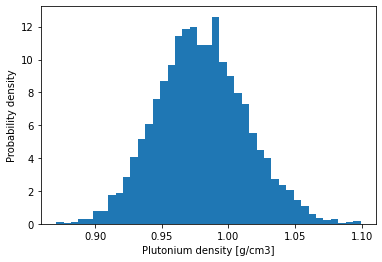

In [16]:
plt.figure()
plt.hist(solv, bins=41, density=True)
plt.xlabel('Plutonium density [g/cm3]')
plt.ylabel('Probability density')
plt.show()